# Semantic Segmentation

In [23]:
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions, CocoDetection
from torchvision import transforms
from pycocotools import mask
from pycocotools.coco import COCO
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import torch.optim as optim
import torch
from torch.utils import data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.segmentation import fcn_resnet50, fcn_resnet101, deeplabv3_resnet50, deeplabv3_resnet101
import torch.nn.functional as F
import os
from tqdm import tqdm
from torchsummary import summary
import datetime
%matplotlib inline

In [2]:
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
os.listdir('/home/euloo/Documents/datasets/coco2017')

['test2017', 'image_info_test', 'val2017', 'annotations', 'train2017']

In [5]:
dataDir = '/home/euloo/Documents/datasets/coco2017'

trainDataType ="train2017"
trainAnnFile = "{}/annotations/instances_{}.json".format(dataDir,trainDataType)

valDataType = "val2017"
valAnnFile = "{}/annotations/instances_{}.json".format(dataDir,valDataType)

In [6]:
class Dataset(CocoDetection):
    def __init__(self, root, annFile, transforms=None, transform=None, target_transform=None):
        super().__init__(root, annFile, transforms, transform, target_transform)
        
#         self.coco_cats = ['__background__', 'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
#                      'car', 'cat', 'chair', 'cow', 'dining table', 'dog', 'horse', 'motorcycle',
#                      'person', 'potted plant', 'sheep', 'couch', 'train', 'tv']
#         cats = self.coco.loadCats(self.coco.getCatIds(catNms=self.coco_cats))
        cats = self.coco.loadCats(self.coco.getCatIds())
        self.id_to_class, self.layer_to_name, self.layer_to_cat = {}, {}, {}
        self.id_to_class[0] = 0
        self.layer_to_name[0] = 'background'
        for it, cat in enumerate(cats):
            self.id_to_class[cat['id']] = it+1
            self.layer_to_name[it+1] = cat['name']
            self.layer_to_cat[cat['id']] = cat['name']
    def to_one_hot(self, tensor, nClasses):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,nClasses,h,w).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot
    
    def __getitem__(self, index):
        img, ann = super().__getitem__(index)
        width, height = img.size[:2]
        msk = np.zeros((height, width))
        
        padding=(
                    320-int(width /2) if width  % 2 == 0 else 320-int(width /2)-1,
                    320-int(height /2) if height  % 2 == 0 else 320-int(height /2)-1,
                    320-int(width /2),
                    320-int(height/2)
                )
        
        img_T = transforms.Compose(([
            transforms.Pad(padding),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
        
        msk_T = transforms.Compose(([
            transforms.ToPILImage(),
            transforms.Pad(padding),
            transforms.ToTensor()
        ]))
        
        categories = set()
        for it in ann:
            if it['category_id'] in self.id_to_class:
                compressed_rle = mask.frPyObjects(it['segmentation'], height, width)
                compressed_rle = compressed_rle if isinstance(compressed_rle, list) else [compressed_rle]
                bw = np.sum(mask.decode(compressed_rle), axis = 2).astype(bool)
                msk[bw] = self.id_to_class[it['category_id']]
                categories.add(self.layer_to_cat[it['category_id']])
        msk = msk_T(msk.astype(np.float32)).long()
        return img_T(img), msk, self.to_one_hot(msk, len(self.id_to_class)), list(categories)
        #return img_T(img), msk_T(msk.astype(np.float32).reshape((height, width))).long(), list(categories)

In [7]:
trainDataType = '/home/euloo/Documents/datasets/coco2017/train2017'
valDataType = '/home/euloo/Documents/datasets/coco2017/val2017'

In [8]:
print(trainAnnFile)
print(valAnnFile)

/home/euloo/Documents/datasets/coco2017/annotations/instances_train2017.json
/home/euloo/Documents/datasets/coco2017/annotations/instances_val2017.json


In [9]:
train_set = Dataset(trainDataType, trainAnnFile)
val_set = Dataset(valDataType, valAnnFile)

loading annotations into memory...
Done (t=16.73s)
creating index...
index created!
loading annotations into memory...
Done (t=2.11s)
creating index...
index created!


In [10]:
train_set.__len__(), val_set.__len__()

(118287, 5000)

In [11]:
#train_set.layer_to_name
#train_set.id_to_class
#train_set.layer_to_cat

In [10]:
img, msk, label, cats = val_set[3]
print(img.shape,msk.shape, label.shape, cats)

torch.Size([3, 640, 640]) torch.Size([1, 640, 640]) torch.Size([1, 81, 640, 640]) ['truck', 'stop sign', 'car']


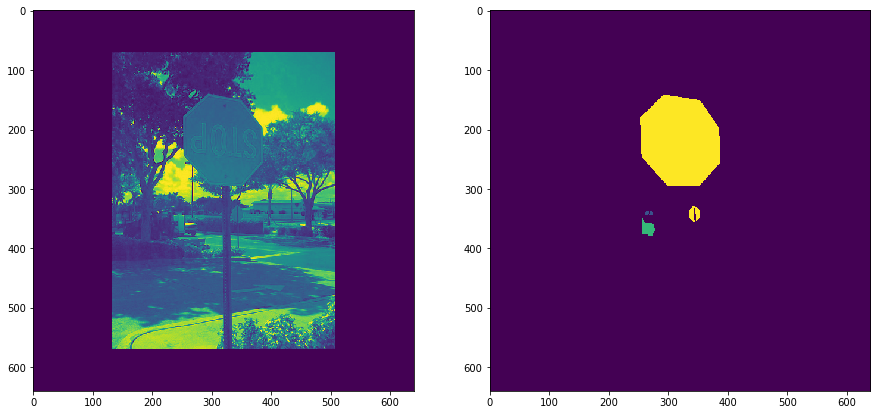

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(img)[0,:,:])
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(msk)[0,:,:]);

~~~
(classifier): FCNHead(
    (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
  )
~~~

In [12]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
#         self.net = deeplabv3_resnet50()
        self.net = fcn_resnet50()
        self.net.classifier[4] = nn.Conv2d(512, 81, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        x = self.net(x)
        return x['out']

In [15]:
model = Net()

In [18]:
#model
model = model.to(device)

In [19]:
train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False)

In [19]:
def rescale(img): # denormalize plot
    return (1/(2.64*2.1179)) * img + 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


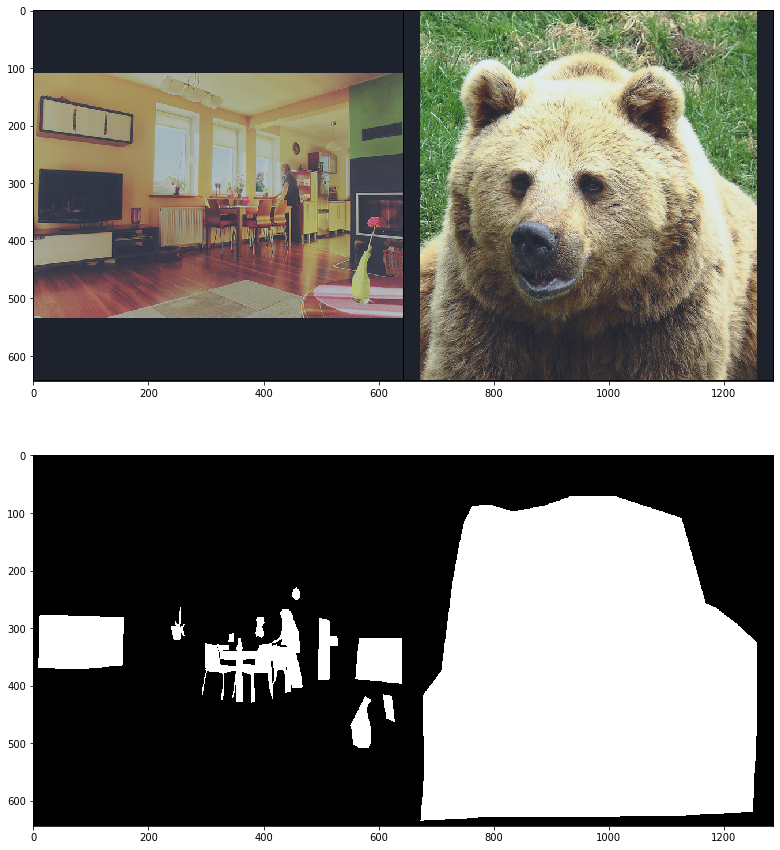

In [20]:
images, labels, cats = next(iter(val_loader))
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.imshow(torchvision.utils.make_grid(rescale(images)).numpy().transpose(1,2,0))
plt.subplot(212)
plt.imshow(torchvision.utils.make_grid(labels.squeeze(0).float()).numpy().transpose(1,2,0))

In [26]:
!nvidia-smi

Sat Nov  9 15:23:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  Off  | 00000000:22:00.0  On |                  N/A |
| 41%   72C    P2    51W / 180W |   2550MiB /  8112MiB |     80%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# mars

In [20]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def forward(self, inputs, target_oneHot):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)

        # Numerator Product
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return -loss.mean()

In [21]:
# pos_weights=torch.FloatTensor([81,81])
# criterion = nn.BCEWithLogitsLoss(pos_weights)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
# criterion = CrossEntropyLoss2d()
# criterion = mIoULoss()

# optimizer = optim.Adam([
#     {'params': [param for name, param in model.named_parameters() if name[-4:] == 'bias'],
#      'lr': 2*1e-5},
#     {'params': [param for name, param in model.named_parameters() if name[-4:] != 'bias'],
#      'lr': 1e-5, 'weight_decay': 1e-4}
# ], betas=(0.95, 0.999))

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [24]:
for epoch in range(3):   
    start=datetime.datetime.now()
    for i, data in enumerate(train_loader):
        if i != 0 and i % 10000 == 0: # too big dataset
            break
        torch.cuda.empty_cache()
        inputs, masks, labels, cats = data
        
        inputs=inputs.cuda()
#         labels=labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        
#         loss = criterion(torch.argmax(outputs, dim=1).unsqueeze(1).cpu().float(), masks.float()) #BCEWithLogitsLoss
        loss = criterion(outputs.cpu(), masks[:,0,:,:].cpu().long()) #CrossEntropyLoss 
#         loss = criterion(outputs, labels) #IoU
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('[%s] [epoch %d]\t[iter %d / %d]\t[train loss %.5f]' % (
                datetime.datetime.now()-start, epoch, i + 1, len(train_loader), loss.item()
            ))
            start=datetime.datetime.now()
    
#     net.eval()

#     for vi, data in enumerate(val_loader):
#         if i != 0 and i % 10000 == 0:
#             break
#         torch.cuda.empty_cache()
#         inputs, masks, labels, cats = data
        
#         inputs=inputs.cuda()
#         labels=labels.cuda()

#         outputs = model(inputs)
       
#         v_loss = criterion(outputs, labels)
#         v_loss = v_loss.item()
        

#     print('--------------------------------------------------------------------')
#     print('[epoch %d]\t[val loss %.5f]' % (
#         epoch, v_loss))

#     print('--------------------------------------------------------------------')

#     net.train()

[0:03:50.283680] [epoch 0]	[iter 100 / 59144]	[train loss 1.03980]
[0:02:59.910775] [epoch 0]	[iter 200 / 59144]	[train loss 1.24395]
[0:02:47.692161] [epoch 0]	[iter 300 / 59144]	[train loss 0.43714]
[0:02:46.838915] [epoch 0]	[iter 400 / 59144]	[train loss 0.91044]
[0:02:48.264667] [epoch 0]	[iter 500 / 59144]	[train loss 0.42257]
[0:02:48.239810] [epoch 0]	[iter 600 / 59144]	[train loss 0.15816]
[0:02:48.038566] [epoch 0]	[iter 700 / 59144]	[train loss 1.27575]
[0:02:47.968075] [epoch 0]	[iter 800 / 59144]	[train loss 2.04219]
[0:02:48.042508] [epoch 0]	[iter 900 / 59144]	[train loss 0.22542]
[0:02:47.492158] [epoch 0]	[iter 1000 / 59144]	[train loss 1.52622]
[0:02:48.543194] [epoch 0]	[iter 1100 / 59144]	[train loss 1.15006]
[0:02:48.685339] [epoch 0]	[iter 1200 / 59144]	[train loss 0.82986]
[0:02:47.920312] [epoch 0]	[iter 1300 / 59144]	[train loss 0.52556]
[0:02:48.256616] [epoch 0]	[iter 1400 / 59144]	[train loss 0.97889]
[0:02:49.094677] [epoch 0]	[iter 1500 / 59144]	[train los

KeyboardInterrupt: 

In [25]:
torch.save(model, '1epoch_7100from10000from59144.pt')

/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type IntermediateLayerGetter. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness

In [26]:
modelnet=torch.load('1epoch_7100from10000from59144.pt')
model.eval()

Net(
  (net): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(in

In [28]:
def rescale(img):
    return (1/(2.64*2.1179)) * img + 0.5

# results
## photo/predicted/gt 

In [568]:
# model = torchvision.models.segmentation.fcn_resnet101(pretrained=True).to(device)
# model.eval()
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)
images, masks, labels, cats = next(iter(val_loader))
with torch.no_grad():
    outputs = model(images.to(device))

[('person', 'toilet')]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


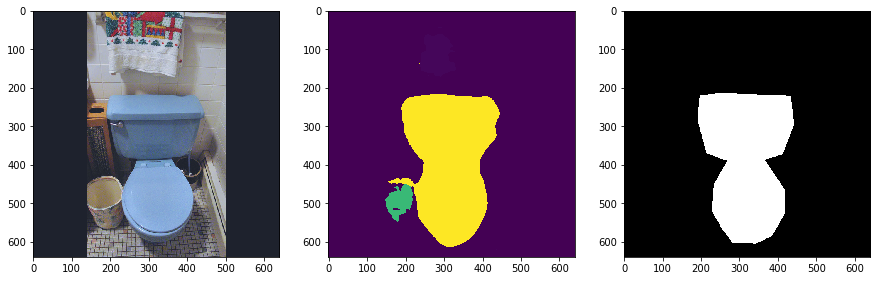

In [569]:
i=1
print(cats)
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(torchvision.utils.make_grid(rescale(images[i].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(torch.argmax(outputs, dim=1)[i].detach().cpu())
plt.subplot(133)
plt.imshow(torchvision.utils.make_grid(masks[i].squeeze(0).float()).numpy().transpose(1,2,0))

[]


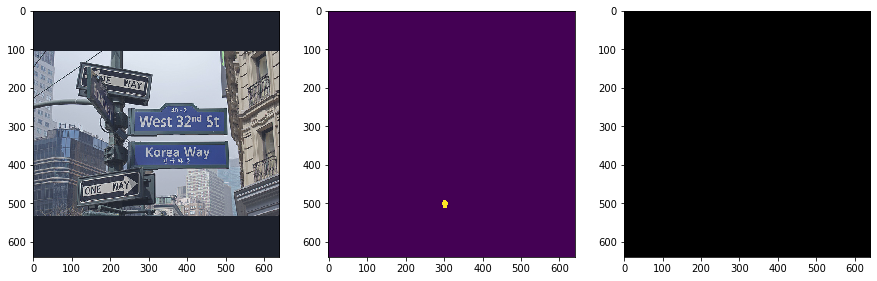

In [65]:
# model = torchvision.models.segmentation.fcn_resnet101(pretrained=True).to(device)
# model.eval()
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)
images, masks, labels, cats = next(iter(val_loader))
with torch.no_grad():
    outputs = model(images.to(device))
i=0
print(cats)
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(torchvision.utils.make_grid(rescale(images[i].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(torch.argmax(outputs, dim=1)[i].detach().cpu())
plt.subplot(133)
plt.imshow(torchvision.utils.make_grid(masks[i].squeeze(0).float()).numpy().transpose(1,2,0))

In [113]:
# model = torchvision.models.segmentation.fcn_resnet101(pretrained=True).to(device)
# model.eval()
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)
images, masks, labels, cats = next(iter(val_loader))
with torch.no_grad():
    outputs = model(images.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('keyboard', 'person'), ('laptop', 'sports ball')]


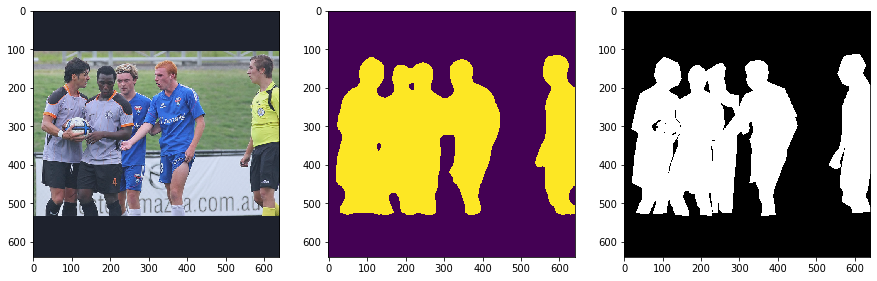

In [114]:

i=1
print(cats)
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(torchvision.utils.make_grid(rescale(images[i].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(torch.argmax(outputs, dim=1)[i].detach().cpu())
plt.subplot(133)
plt.imshow(torchvision.utils.make_grid(masks[i].squeeze(0).float()).numpy().transpose(1,2,0))

In [154]:
# model = torchvision.models.segmentation.fcn_resnet101(pretrained=True).to(device)
# model.eval()
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)
images, masks, labels, cats = next(iter(val_loader))
with torch.no_grad():
    outputs = model(images.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('cat', 'bear')]


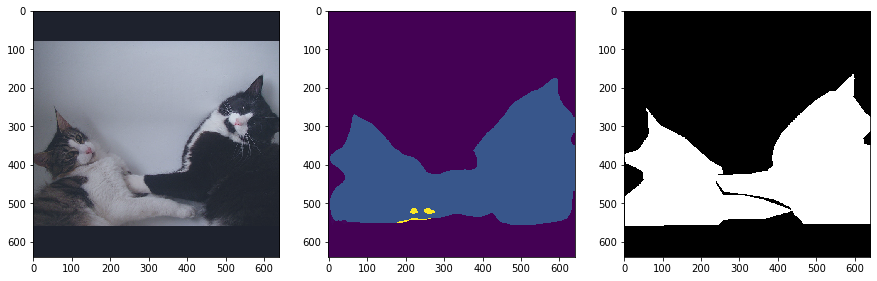

In [157]:

i=0
print(cats)
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(torchvision.utils.make_grid(rescale(images[i].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(torch.argmax(outputs, dim=1)[i].detach().cpu())
plt.subplot(133)
plt.imshow(torchvision.utils.make_grid(masks[i].squeeze(0).float()).numpy().transpose(1,2,0))

[('cake', 'person'), ('dining table', 'chair'), ('fork', 'sports ball')]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


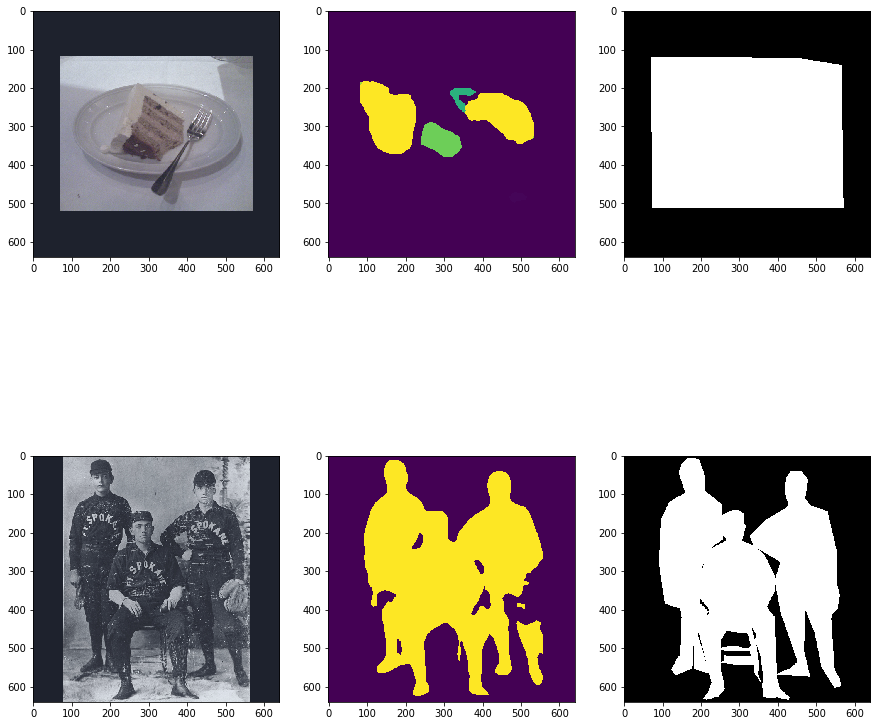

In [275]:
# model = torchvision.models.segmentation.fcn_resnet101(pretrained=True).to(device)
# model.eval()
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)
images, masks, labels, cats = next(iter(val_loader))
with torch.no_grad():
    outputs = model(images.to(device))

print(cats)
plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(torchvision.utils.make_grid(rescale(images[0].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(232)
plt.imshow(torch.argmax(outputs, dim=1)[0].detach().cpu())
plt.subplot(233)
plt.imshow(torchvision.utils.make_grid(masks[0].squeeze(0).float()).numpy().transpose(1,2,0))
plt.subplot(234)
plt.imshow(torchvision.utils.make_grid(rescale(images[1].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(235)
plt.imshow(torch.argmax(outputs, dim=1)[1].detach().cpu())
plt.subplot(236)
plt.imshow(torchvision.utils.make_grid(masks[1].squeeze(0).float()).numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]


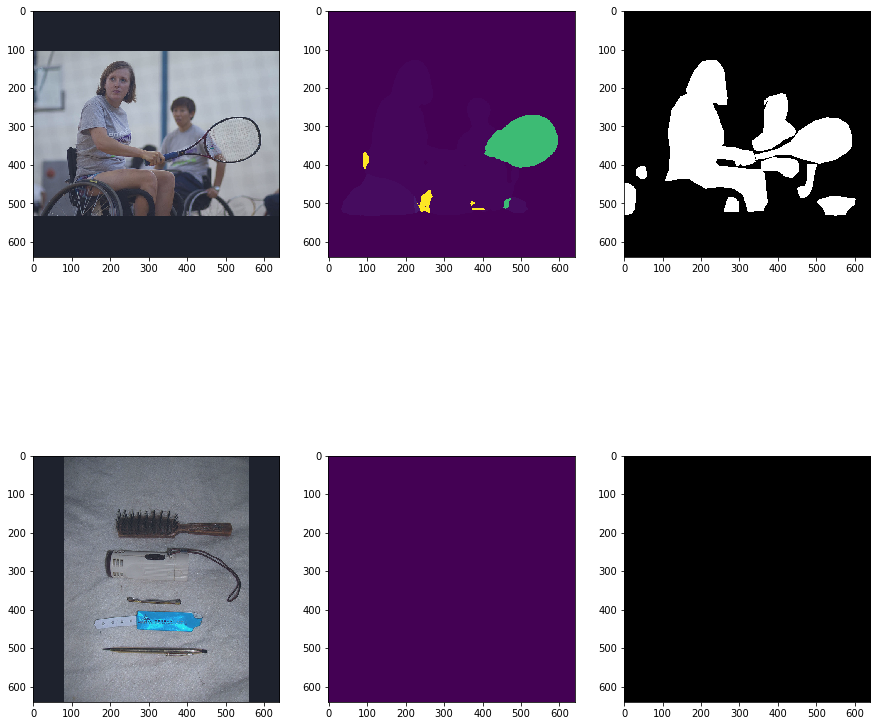

In [309]:
# model = torchvision.models.segmentation.fcn_resnet101(pretrained=True).to(device)
# model.eval()
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)
images, masks, labels, cats = next(iter(val_loader))
with torch.no_grad():
    outputs = model(images.to(device))

print(cats)

plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(torchvision.utils.make_grid(rescale(images[0].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(232)
plt.imshow(torch.argmax(outputs, dim=1)[0].detach().cpu())
plt.subplot(233)
plt.imshow(torchvision.utils.make_grid(masks[0].squeeze(0).float()).numpy().transpose(1,2,0))
plt.subplot(234)
plt.imshow(torchvision.utils.make_grid(rescale(images[1].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(235)
plt.imshow(torch.argmax(outputs, dim=1)[1].detach().cpu())
plt.subplot(236)
plt.imshow(torchvision.utils.make_grid(masks[1].squeeze(0).float()).numpy().transpose(1,2,0))